In [ ]:
#clones gitHub repo with cell images
!git clone https://github.com/jlevy44/PreliminaryGenerativeHistoPath.git

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stat

# Set the paths to the input folders containing X and Y PNG images
dataPath = "/content/PreliminaryGenerativeHistoPath/cyto2label_public"
trainDir = dataPath + "/train" 
testDir = dataPath + "/test"
valDir = dataPath + "/val"



In [3]:
trainPaths = os.listdir(trainDir)
testPaths = os.listdir(testDir)
valPaths = os.listdir(valDir)

trainSegs = np.zeros((len(trainPaths), 227, 227, 3))
trainImgs = np.zeros((len(trainPaths), 227, 227, 3))

testSegs = np.zeros((len(testPaths), 227, 227, 3))
testImgs = np.zeros((len(testPaths), 227, 227, 3))

valSegs = np.zeros((len(valPaths), 227, 227, 3))
valImgs = np.zeros((len(valPaths), 227, 227, 3))


In [4]:
#Counts blue and green pixels, returns nc ratio
def pixCount(img):
  nucleus = 0
  cytoplasm = 0
  for row in img:
    for pix in row:
      r = pix[0]
      g = pix[1]
      b = pix[2]
      if(r == 0 and g == 0 and b == 255):
        nucleus += 1
      if(r == 0 and g == 255 and b == 0):
        cytoplasm += 1

  return(nucleus, cytoplasm, nucleus/(cytoplasm + nucleus))

In [5]:
def pixCountMod(img): #not all white values have perfect 255, 255, 255 proved by this method
                  #but all blue and green values have perfect 255 vals. This method isn't actually used
  nucleus = 0
  cytoplasm = 0
  for row in img:
    for pix in row:
      r = int(pix[0])
      g = int(pix[1])
      b = int(pix[2])
      if(b > (g + r)):
        print("b: "+ str(pix))
        nucleus += 1
      if(g > (b + r)):
        print("g: "+ str(pix))
        cytoplasm += 1

  return(nucleus, cytoplasm, nucleus/(cytoplasm + nucleus))

In [ ]:
#seperates training images and segment masks, puts into np arrays
for i in range(len(trainPaths)):
  print(trainPaths[i])
  img = Image.open(trainDir +"/" + trainPaths[i])

  normImg = img.crop((0, 0, 227, 227))
  segImg = img.crop((227, 0, 454, 227))

  normImg = np.array(normImg)
  segImg = np.array(segImg)

  trainImgs[i] = normImg
  trainSegs[i] = segImg

In [ ]:
#seperates test images and segment masks, puts into np arrays. Also finds nc ratio of each image
ncRatios = []

for i in range(len(testPaths)):
  print(testPaths[i])
  img = Image.open(testDir +"/" + testPaths[i])

  normImg = img.crop((0, 0, 227, 227))
  segImg = img.crop((227, 0, 454, 227))

  normImg = np.array(normImg)
  segImg = np.array(segImg)
  nucleus, cytoplasm, ncRatio = pixCount(segImg)
  print("n: " + str(nucleus) + " c: " + str(cytoplasm) + "ratio: " + str(ncRatio))
  ncRatios.append(ncRatio)

  testImgs[i] = normImg
  testSegs[i] = segImg

In [ ]:
#seperates validation images and segment masks, puts into np arrays
for i in range(len(valPaths)):
  print(valPaths[i])
  img = Image.open(valDir +"/" + valPaths[i])

  normImg = img.crop((0, 0, 227, 227))
  segImg = img.crop((227, 0, 454, 227))

  normImg = np.array(normImg)
  segImg = np.array(segImg)

  valImgs[i] = normImg
  valSegs[i] = segImg

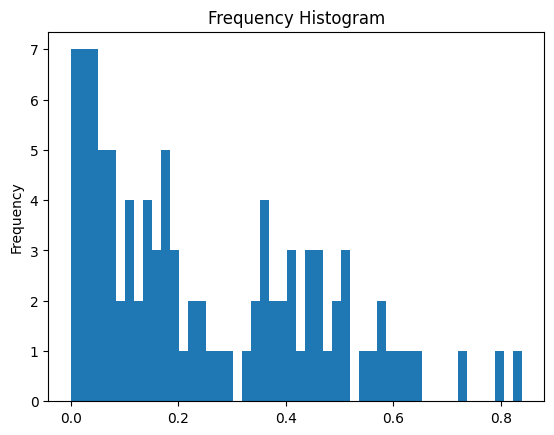

In [55]:
#plots nc ratios
plt.hist(ncRatios, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [10]:
class GeneTester: #from part 1

    def __init__(self, path):
        self.df = pd.read_csv(path)
    def average(arr):
        sum = 0
        for val in arr:
            sum+=val
        mean = sum / len(arr)
        return mean

    def populationSD(arr, mean):
        varianceSum = 0
        for val in arr:
            dif = abs(val - mean)
            difSqr = dif ** 2
            varianceSum += difSqr
        variance = varianceSum / len(arr)

        SD = variance ** 0.5
        return SD

    def sampleSD(arr, mean):
        varianceSum = 0
        for val in arr:
            dif = abs(val - mean)
            difSqr = dif ** 2
            varianceSum += difSqr
        variance = varianceSum / (len(arr) - 1)

        SD = variance ** 0.5
        return SD

    def standardError(SD, n):
        return SD / (n ** 0.5)

    def criticalVal(mean, SD, thresh):
        dif = thresh - mean
        critVal = dif / SD
        return critVal

    def zTest(critVal):
        p = stat.norm.cdf(critVal)
        return p
    
    def probability(arr, thresh):
        length = len(arr)
        mean = GeneTester.average(arr)
        SD = GeneTester.populationSD(arr, mean)
        #print(SD)
        SE = GeneTester.standardError(SD, length)
        critVal = GeneTester.criticalVal(mean, SE, thresh)
        p = GeneTester.zTest(critVal)
        return p
    def iterData(self):
        for series in self.df.iloc:
            geneType = series[0]
            series = series[1:]
            arr = []
            for val in series:
                arr.append(val)
            p = GeneTester.probability(arr)
            print(geneType + " probability good gene: " + str(p))
    def plot(self, gene1, gene2):
        arr1 = self.df.iloc[gene1][1:]
        arr2 = self.df.iloc[gene2][1:]
        print("x axis gene: " + str(gene1))
        print("y axis gene: " + str(gene2))
        plt.scatter(arr1, arr2)
        plt.show()

In [75]:
#finds probability that nc ratio doesn't exceed threshold
thresh = 0.3
probability = GeneTester.probability(ncRatios, thresh)
print(probability)

0.9909086179544453


In [70]:
print("probability cell population is malignant: " + str(round(((1 - probability) * 100), 10)) + "%" ) 

probability cell population is malignant: 1.4e-09%


In [13]:

def seperateBackground(img):  #gives background red and gives all pixels perfect 255 values
  newImg = np.copy(img)       #Also adds padding to make images 256x256
  
  pad_size = ((14, 15), (14, 15), (0, 0)) 

  newImg = np.pad(newImg, pad_size, mode='constant', constant_values=255)

  for row in newImg:
    for pix in row:
      r = pix[0]
      g = pix[1]
      b = pix[2]
      if(b > r + g):
        pix[0] = 0
        pix[1] = 0
        pix[2] = 255
      elif(g > r + b):
        pix[0] = 0
        pix[1] = 255
        pix[2] = 0
      else:
        pix[0] = 255
        pix[1] = 0
        pix[2] = 0
  
      

  return newImg

In [14]:
trainBackgrounds = np.zeros((len(trainPaths), 256, 256, 3))
testBackgrounds = np.zeros((len(trainPaths), 256, 256, 3))
valBackgrounds = np.zeros((len(trainPaths), 256, 256, 3))

In [15]:
def padding(img): #adds padding to make images 256x256
  pad_size = ((14, 15), (14, 15), (0, 0)) 


  newImg = np.pad(img, pad_size, mode='constant', constant_values=255)
  return newImg

In [16]:
#makes np array with padded images
trainImgsPad = np.zeros((len(trainImgs), 256, 256, 3))
for i in range(len(trainImgs)):
  trainImgsPad[i] = padding(trainImgs[i])

testImgsPad = np.zeros((len(testImgs), 256, 256, 3))
for i in range(len(testImgs)):
  testImgsPad[i] = padding(testImgs[i])

valImgsPad = np.zeros((len(valImgs), 256, 256, 3))
for i in range(len(valImgs)):
  valImgsPad[i] = padding(valImgs[i])

In [17]:
#makes np array with image segmented into red(background) green and blue
for i in range(len(trainSegs)):
  background = seperateBackground(trainSegs[i])
  trainBackgrounds[i] = background

for i in range(len(testSegs)):
  background = seperateBackground(testSegs[i])
  testBackgrounds[i] = background

for i in range(len(valSegs)):
  background = seperateBackground(valSegs[i])
  valBackgrounds[i] = background

In [18]:
#Normalize pixel values from 0-255 to 0-1
trainBackgrounds = trainBackgrounds / 255
trainImgsPad = trainImgsPad / 255

testBackgrounds = testBackgrounds / 255
testImgsPad = testImgsPad / 255

valBackgrounds = valBackgrounds / 255
valImgsPad = valImgsPad / 255

In [21]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [22]:
#each encoder block uses convolutional layer to make "half" size filter maps
def define_encoder_block(layer_in, n_filters, filtSize, stride, batchnorm=True):
 init = RandomNormal(stddev=0.02)
 g = Conv2D(n_filters, (filtSize, filtSize), strides=(stride, stride), padding='same',
            kernel_initializer=init)(layer_in)
 if batchnorm:
  g = BatchNormalization()(g, training=True)
 g = LeakyReLU(alpha=0.2)(g)
 return g
 
#each encoder block uses convolutional layer to make "double" size filter maps
def decoder_block(layer_in, skip_in, n_filters, filtSize, stride, dropout=True):
 init = RandomNormal(stddev=0.02)
 g = Conv2DTranspose(n_filters, (filtSize, filtSize), strides=(stride, stride), padding='same', kernel_initializer=init)(layer_in)
 g = BatchNormalization()(g, training=True)
 if dropout:
  g = Dropout(0.5)(g, training=True)
 g = Concatenate()([g, skip_in])
 g = Activation('relu')(g)
 return g

#makes U-net that brings image from 256x256 down to 32x32, then back to 256x256.
def define_generator(image_shape=(256,256,3)):
 init = RandomNormal(stddev=0.02)
 in_image = Input(shape=image_shape)
 #encoder
 e1 = define_encoder_block(in_image, 64, 4, 2, batchnorm=False)
 e2 = define_encoder_block(e1, 128, 4, 2)
 e3 = define_encoder_block(e2, 256, 4, 2)
 e4 = define_encoder_block(e3, 512, 4, 2)
 e5 = define_encoder_block(e4, 512, 4, 2)

 b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e5) #should be e7
 b = Activation('relu')(b)
 # decoder
 d3 = decoder_block(b, e5, 512, 4, 2)
 d4 = decoder_block(d3, e4, 512, 4 ,2, dropout=False)
 d5 = decoder_block(d4, e3, 256, 4, 2, dropout=False)
 d6 = decoder_block(d5, e2, 128, 4, 2, dropout=False)
 d7 = decoder_block(d6, e1, 64, 4, 2, dropout=False)

 g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
 out_image = Activation('tanh')(g)
# define model
 model = Model(in_image, out_image)
 return model

In [23]:
model = define_generator()

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
model.summary()

In [25]:
#mean absolute error loss to bring pix values close to target
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint



checkpoint_filepath = 'model_checkpoint.h5'

# saves model every 10 epochs
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                       save_freq='epoch', 
                                       save_best_only=False, 
                                       save_weights_only=False, 
                                       verbose=1, 
                                       period=10)

# train model for 200 epochs
model.fit(trainImgsPad, trainBackgrounds, validation_data=(testImgsPad, testBackgrounds), epochs=200, batch_size=64, callbacks=[checkpoint_callback])

In [ ]:
#reaches 0.06 mean absolute error for validation , lots of random "spots" throughout the image, 9 mins runtime

In [28]:
#predictions on testing data
preds = model.predict(testImgsPad)

4/4 [==============================] - 6s 648ms/step


In [30]:
#makes normalized images(0-1) back to normal rgb format(0-255)
preds *= 255
preds = preds.astype('uint8')

In [32]:
%cd preAbsolute

/content/preAbsolute


In [33]:
#adds prediction images before post processing to a folder
for i in range(len(preds)):
  img = Image.fromarray(preds[i].astype("uint8"))
  img.save(testPaths[i])
  

In [34]:
#changes the "uncertain" values that are somewhere beteen 0 and 255, into either red, green, or blue
for img in preds:
  for row in img:
    for pix in row:
      r = int(pix[0])
      g = int(pix[1])
      b = int(pix[2])
      if(r > g and r > b):
          pix[0] = 255
          pix[1] = 255
          pix[2] = 255
      
      elif(g > r and g > b):
          pix[0] = 0
          pix[1] = 255
          pix[2] = 0
      
      else:
          pix[0] = 0
          pix[1] = 0
          pix[2] = 255


In [35]:
#Changes pixels that are completely white in the initial images(before running through model)
#into white
testImgsPad = testImgsPad * 255
print(testImgsPad)
testImgsPad.astype('uint8')
for a in range(len(testImgs)):
  background = seperateBackground(testImgsPad[a])
  for i in range(256):
    for j in range(256):
      if testImgsPad[a][i][j][0] == 255 and testImgsPad[a][i][j][1] == 255 and testImgsPad[a][i][j][2] == 255:
        preds[a][i][j][0] = 255
        preds[a][i][j][1] = 255
        preds[a][i][j][2] = 255

In [37]:
%cd postAbsolute

/content/postAbsolute


In [38]:
#adds prediction images after post processing to a folder
for i in range(len(preds)):
  img = Image.fromarray(preds[i].astype("uint8"))
  img.save(testPaths[i])
  

In [ ]:
#finds nc ratios for each of the predicted segment masks
predNcRatios = []
for i in range(len(preds)):
  nucleus, cytoplasm, ncRatio = pixCount(preds[i])
  print("n: " + str(nucleus) + " c: " + str(cytoplasm) + "ratio: " + str(ncRatio))
  predNcRatios.append(ncRatio)

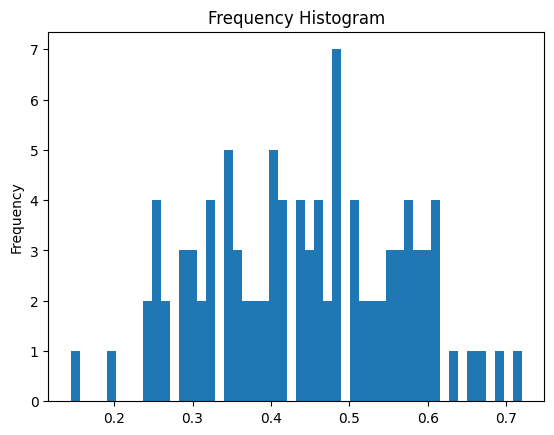

In [60]:
#plots predicted nc ratios
plt.hist(predNcRatios, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [73]:
#finds probability that nc ratios are below threshold
thresh = 0.3
Predprobability = GeneTester.probability(predNcRatios, thresh)
print(Predprobability)

1.2495598475479641e-31


In [74]:
print("probability cell population is malignant: " + str(round(((1 - Predprobability) * 100), 10)) + "%" ) 

probability cell population is malignant: 100.0%
